In this example, we will load up a sample whole slide image (WSI), check out some key information, then extract some image patches from it. From this, we will examine `wsireader`, `slide_info`, and multiprocessing modules of the library.

We start by importing some related libraries. Then, we will download a small WSI which is available from the web. Readers can switch to your WSI of choices by changing `sample_file_name` variable. Readers should also direct `run_dir` location toward your where you currently store the network. In case of downloading from the web, the sample WSI will be saved under the name defined in `sample_file_name` within the `run_dir` folder. Subsequently, we will load up the WSI of name `sample_file_name` from the `run_dir` directory.

In [1]:
from tiatoolbox.dataloader.slide_info import slide_info
from tiatoolbox.dataloader import wsireader
import requests
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

mpl.rcParams['figure.dpi'] = 300 # for hires figure in notebook

run_dir = '/home/tialab-dang/workspace/project/tiatoolbox/'
sample_file_name = 'sample_wsi_small.svs'

In [2]:
if not os.path.exists('%s/%s' % (sample_file_name, run_dir)):
    r = requests.get(
        "http://openslide.cs.cmu.edu/download/openslide-testdata/Aperio/CMU-1-Small-Region.svs"
    )
    with open('%s/sample_wsi_small.svs' % run_dir, "wb") as f:
        f.write(r.content)

Now, we will create a `WSIReader` object to load the information from WSI. For this class, the `input_dir` means the path to directory which contains the target, while the `file_name` keyword points to the specific file within the folder. 

In [3]:
# create a file handler
wsi_reader = wsireader.WSIReader(
                input_dir=run_dir, 
                file_name=sample_file_name)

Let's check the magnification available from this WSI as well as its dimension at base level (highest available magnification).

In [4]:
wsi_info = wsi_reader.slide_info()
print('Highest Magnification', wsi_info['objective_power'])
print('Dimension at highest magnification', wsi_info['slide_dimension'])
print('Available Level of Magnification', wsi_info['level_count'])
print('The down-sample ratio of each level with respect to the base-level', wsi_info['level_downsamples'])

Highest Magnification 20
Dimension at highest magnification (2220, 2967)
Available Level of Magnification 1
The down-sample ratio of each level with respect to the base-level (1.0,)


Now, we will check the WSI thumbnail, which is loaded at x1.25 magnification.

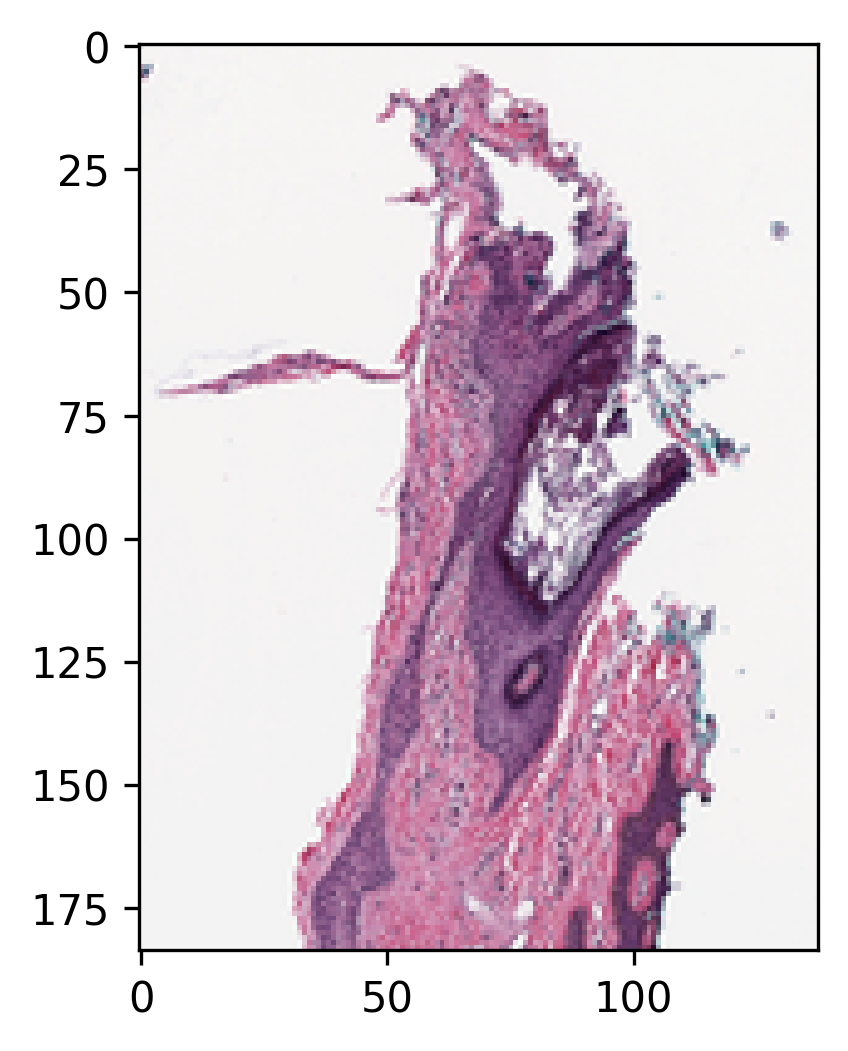

In [5]:
wsi_thumb = wsi_reader.slide_thumbnail()
plt.imshow(wsi_thumb)

Once that's done, we will write up a small function using `scikit` and `scipy` to get the tissue regions and create image patches from it. We first define `simple_get_mask` function which will read in the wsi thumbnail in RGB form, then we will threshold its intensity to separate the tissue out from the background, some minor operations such as dilation are applied subsequently to prettify the output. We often call the area highlight a specific region in the image as mask.

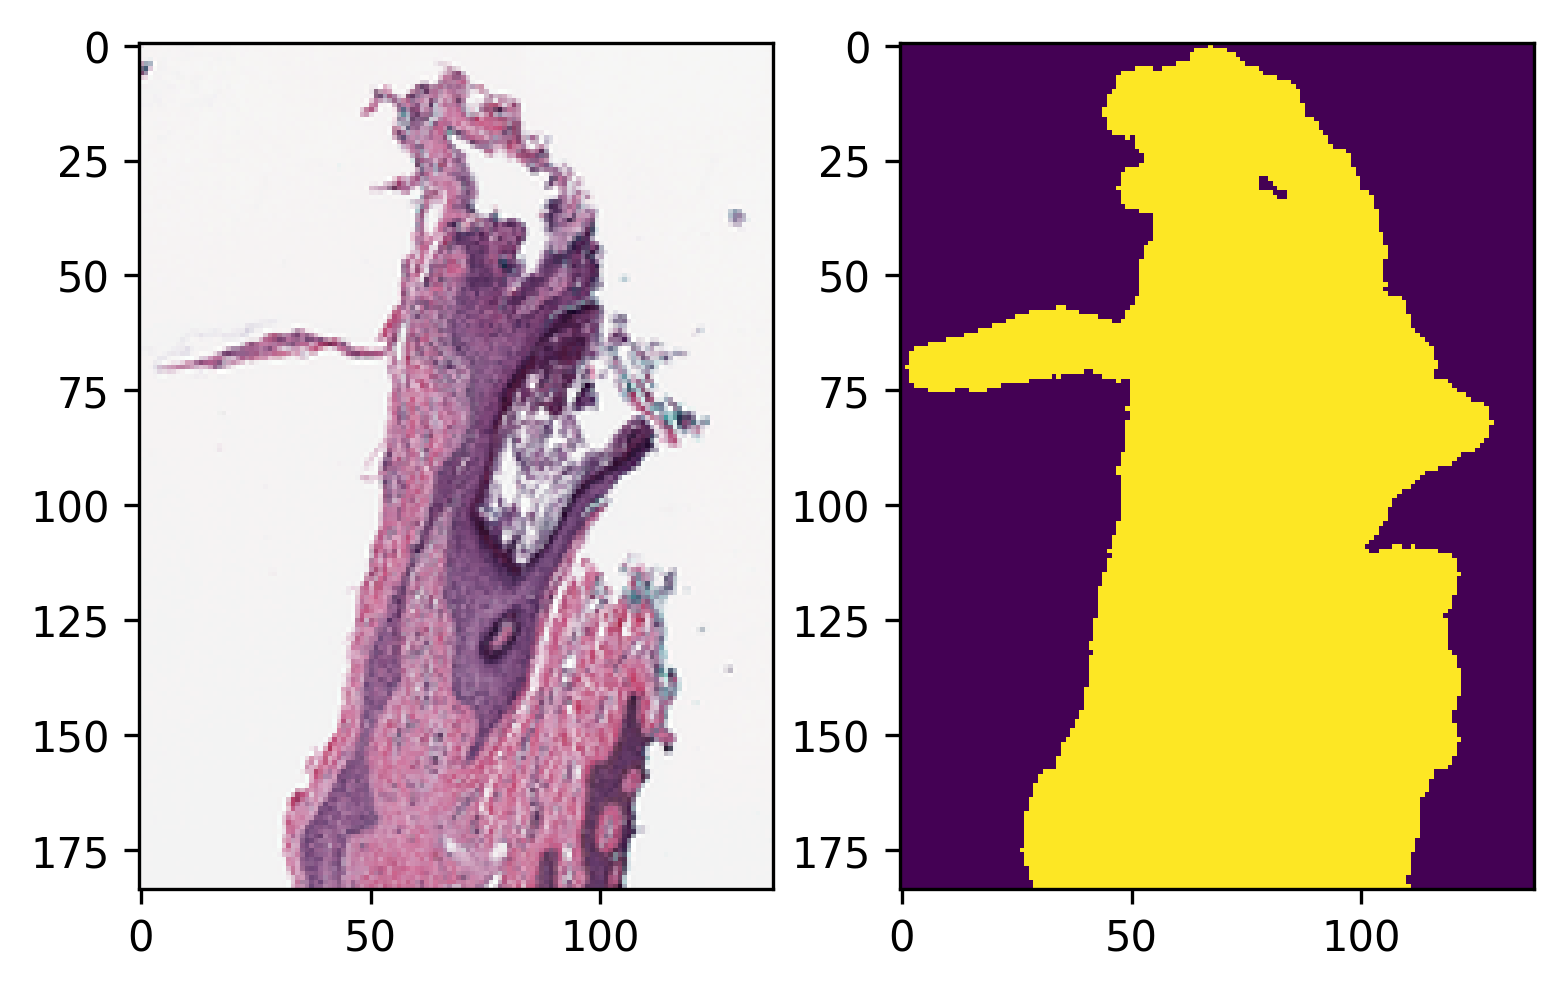

In [6]:
import cv2
import math
from skimage import morphology

# simple method to extract tissue regions using intensity thresholding and morphological operations
def simple_get_mask(rgb):
    gray = cv2.cvtColor(rgb, cv2.COLOR_RGB2GRAY)
    _, mask = cv2.threshold(gray, 0, 255, cv2.THRESH_OTSU)
    mask = morphology.remove_small_objects(mask == 0, min_size=100, connectivity=2)
    mask = morphology.remove_small_holes(mask, area_threshold=100)
    mask = morphology.binary_dilation(mask, morphology.disk(5))
    return mask

wsi_thumb_mask = simple_get_mask(wsi_thumb)
plt.subplot(1,2,1)
plt.imshow(wsi_thumb)
plt.subplot(1,2,2)
plt.imshow(wsi_thumb_mask)

Then, we write a function to find the location to extract the patches. The location is defined as its top left location with repspect to the top left corner of the source image and its dimension (heigh and width). 

For computation region, the operation is done at the thumbnail level, so we will need to map the patches location and its size back to the targetted magnification we want to extract later.

In [8]:
from scipy.ndimage.measurements import center_of_mass
from skimage.segmentation import slic
from skimage.segmentation import mark_boundaries

# get the super-pixels (a.k.a rois) of the tissue area and extract 
# patches centering those super-pixel (a.k.a rois)
lores_mag = 1.25 # the magnification of the thumbnail (lores = low resolution)
hires_mag = 20 # the magnification where the patch would be extracted (hires = high resolution)
hires_patch_size = 128 # expected output patch size at higher resolution
# map the expected patch size at hires to lores
lores_patch_size = int(hires_patch_size / (hires_mag / lores_mag))

For this example, we would like to create image patches such that they can cover the entire WSI. We will use the super-pixel algorithm SLIC from `scikit` to do this. It will split the tissue region into regions of similar size at low resolution. Then we get the patches which center these region.

#Actual Patches / #Expected Patches : 200/199


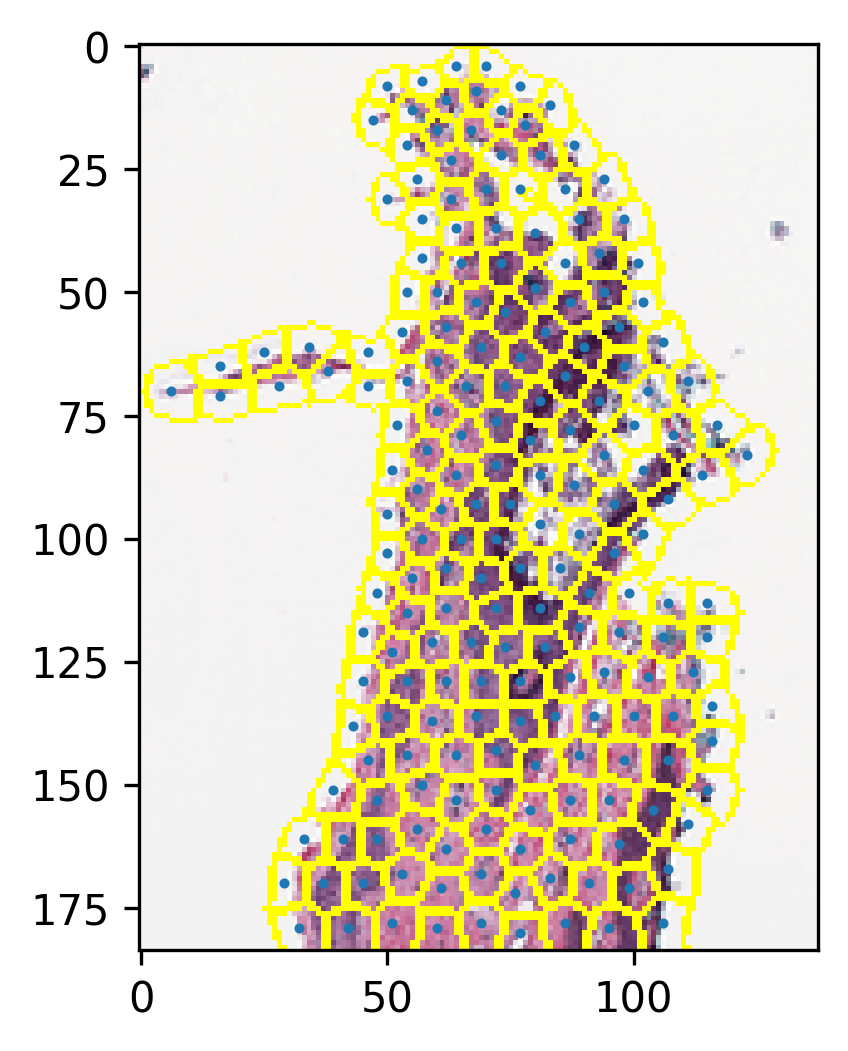

In [9]:

# calculate the expected number of patches can be obtain with the given size
# however, note that the actual number of patches may not be the same as expected
nr_expected_rois = math.ceil(np.sum(wsi_thumb_mask) / ((lores_patch_size ** 2)))
wsi_rois_mask = slic(wsi_thumb, 
                    mask=wsi_thumb_mask,
                    n_segments=nr_expected_rois, 
                    compactness=1000, 
                    sigma=1)
print('#Actual Patches / #Expected Patches : %d/%d' \
        % (np.unique(wsi_rois_mask).shape[0], nr_expected_rois))

lores_rois_center = center_of_mass(wsi_rois_mask, 
                labels=wsi_rois_mask, 
                index=np.unique(wsi_rois_mask)[1:])
lores_rois_center = np.array(lores_rois_center) # coordinates is Y, X
lores_rois_center = (lores_rois_center).astype(np.int32)
selected_indices = wsi_thumb_mask[lores_rois_center[:,0],lores_rois_center[:,1]]
lores_rois_center = lores_rois_center[selected_indices]

# show the patches region and their center of masses
plt.imshow(mark_boundaries(wsi_thumb, wsi_rois_mask))
plt.scatter(lores_rois_center[:,1], lores_rois_center[:,0], s=2)


We then convert the centers of each regions to the top-left position of the patches at high resolution.

In [10]:
# convert to top left idx at hires_mag level
lores_rois_top_left = (lores_rois_center - (lores_patch_size // 2))
hires_rois_top_left = lores_rois_top_left * (hires_mag / lores_mag)
hires_rois_top_left = hires_rois_top_left.astype(np.int32) 

Then, we will load up some patches parallely using the `TIAMultiProcess` decorator and check its contain. For illustration purposes, only 64 are loaded. Reader can change the number of display accordingly via `nr_viz_patches`.

(-0.5, 511.5, 511.5, -0.5)

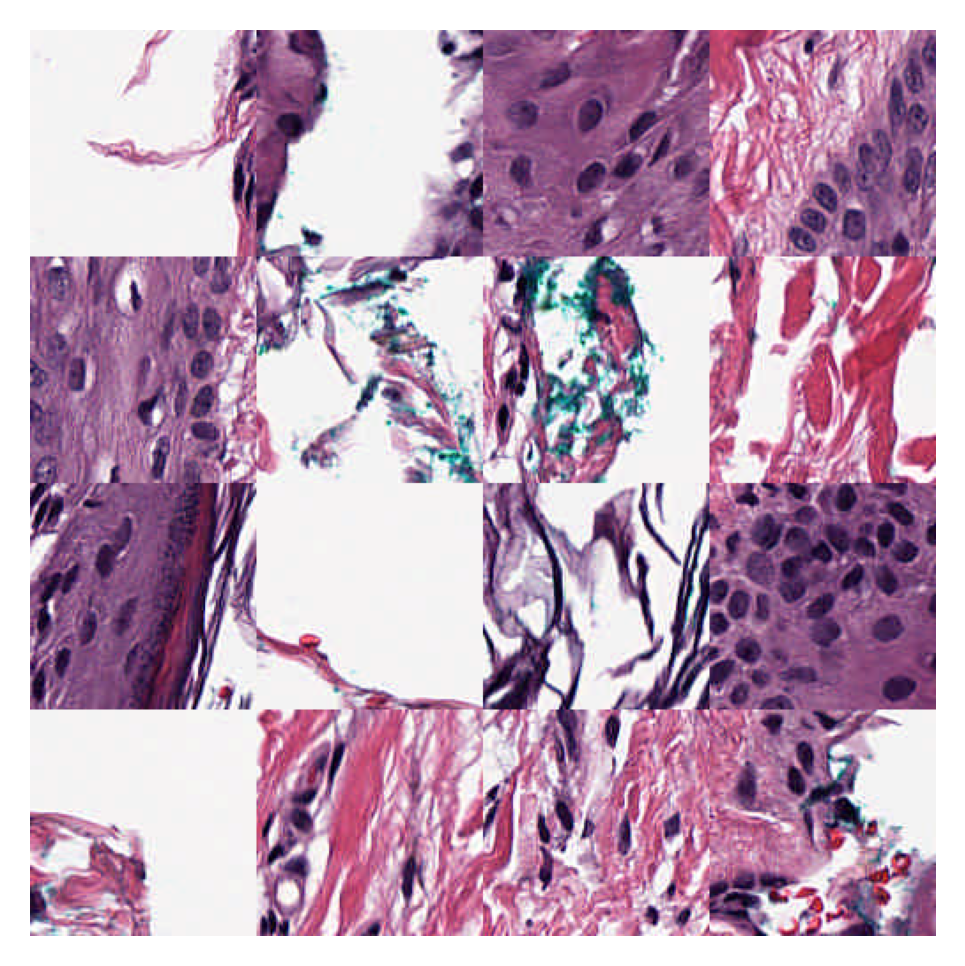

In [11]:
nr_viz_patches = 16

from tiatoolbox.decorators.multiproc import TIAMultiProcess

# for illustration purpose, only read a small amount
selected_indices = np.random.randint(0, hires_rois_top_left.shape[0], size=(4*nr_viz_patches,))
hires_rois_top_left = hires_rois_top_left[selected_indices] 

@TIAMultiProcess(iter_on="patch_coord")
def extract_patches(patch_coord): # patch_coord is top left coord, in Y, X
    img = wsi_reader.read_region(
                        patch_coord[1], patch_coord[0],
                        patch_coord[1]+hires_patch_size, 
                        patch_coord[0]+hires_patch_size,
                        level=0)
    return img
patches_list = extract_patches(patch_coord=hires_rois_top_left, workers=2)

# plot the first 16
sub_patches = np.array(patches_list[:16])
sub_patches = np.reshape(sub_patches, (4, 4, hires_patch_size, hires_patch_size, 3))
sub_patches = np.transpose(sub_patches, (0, 2, 1, 3, 4))
sub_patches = np.reshape(sub_patches, (4 * hires_patch_size, 4 * hires_patch_size, 3))
plt.imshow(sub_patches)
plt.axis('off')


Conversely, if you want to extract the entire wsi (including the background). You can use the built-in `save_tiles` functionality of each `WSIReader` object.

We start by creating another `WSIReader` object with keyword `tile_objective_value`, `tile_read_size_h`, `tile_read_size_w`, and `output_dir`. They repsectively define the magnification where the patches will be read, their expected height and expected width, and where they will be saved. For terminology, tile means image patches at sizeable dimension. For this, tiles are read at x20, each of size 1000x1000 and will be saved at the `tmp` folder within the `run_dir`.

In [14]:
# create a file handler
wsi_reader_v2 = wsireader.WSIReader(
                input_dir=run_dir,
                file_name=sample_file_name,
                output_dir=run_dir + '/tmp',
                tile_objective_value=20,
                tile_read_size_h=1000,
                tile_read_size_w=1000)
wsi_reader_v2.save_tiles()

Tile0:  start_w:0, end_w:1000, start_h:0, end_h:1000, width:1000, height:1000
Tile1:  start_w:1000, end_w:2000, start_h:0, end_h:1000, width:1000, height:1000
Tile2:  start_w:2000, end_w:2220, start_h:0, end_h:1000, width:220, height:1000
Tile3:  start_w:0, end_w:1000, start_h:1000, end_h:2000, width:1000, height:1000
Tile4:  start_w:1000, end_w:2000, start_h:1000, end_h:2000, width:1000, height:1000
Tile5:  start_w:2000, end_w:2220, start_h:1000, end_h:2000, width:220, height:1000
Tile6:  start_w:0, end_w:1000, start_h:2000, end_h:2967, width:1000, height:967
Tile7:  start_w:1000, end_w:2000, start_h:2000, end_h:2967, width:1000, height:967
Tile8:  start_w:2000, end_w:2220, start_h:2000, end_h:2967, width:220, height:967


Now, we will check the content of the output folder and plot some tiles for visualization. The extracted tiles would be saved under a subfolder having the WSI name as its name, andThe output folder would contain a `.csv` which summarize the extracted tiles.

In [15]:

import cv2
import pandas as pd

tile_summary = pd.read_csv('%s/tmp/%s/Output.csv' % (run_dir, sample_file_name))
print(tile_summary)


iter              Tile_Name  start_w  end_w  start_h  end_h  size_w  size_h
0     0        Tile_20_0_0.jpg        0   1000        0   1000    1000    1000
1     1     Tile_20_1000_0.jpg     1000   2000        0   1000    1000    1000
2     2     Tile_20_2000_0.jpg     2000   2220        0   1000    1000     220
3     3     Tile_20_0_1000.jpg        0   1000     1000   2000    1000    1000
4     4  Tile_20_1000_1000.jpg     1000   2000     1000   2000    1000    1000
5     5  Tile_20_2000_1000.jpg     2000   2220     1000   2000    1000     220
6     6     Tile_20_0_2000.jpg        0   1000     2000   2967     967    1000
7     7  Tile_20_1000_2000.jpg     1000   2000     2000   2967     967    1000
8     8  Tile_20_2000_2000.jpg     2000   2220     2000   2967     967     220


We will plot `Tile_20_1000_1000.jpg` as sample output.

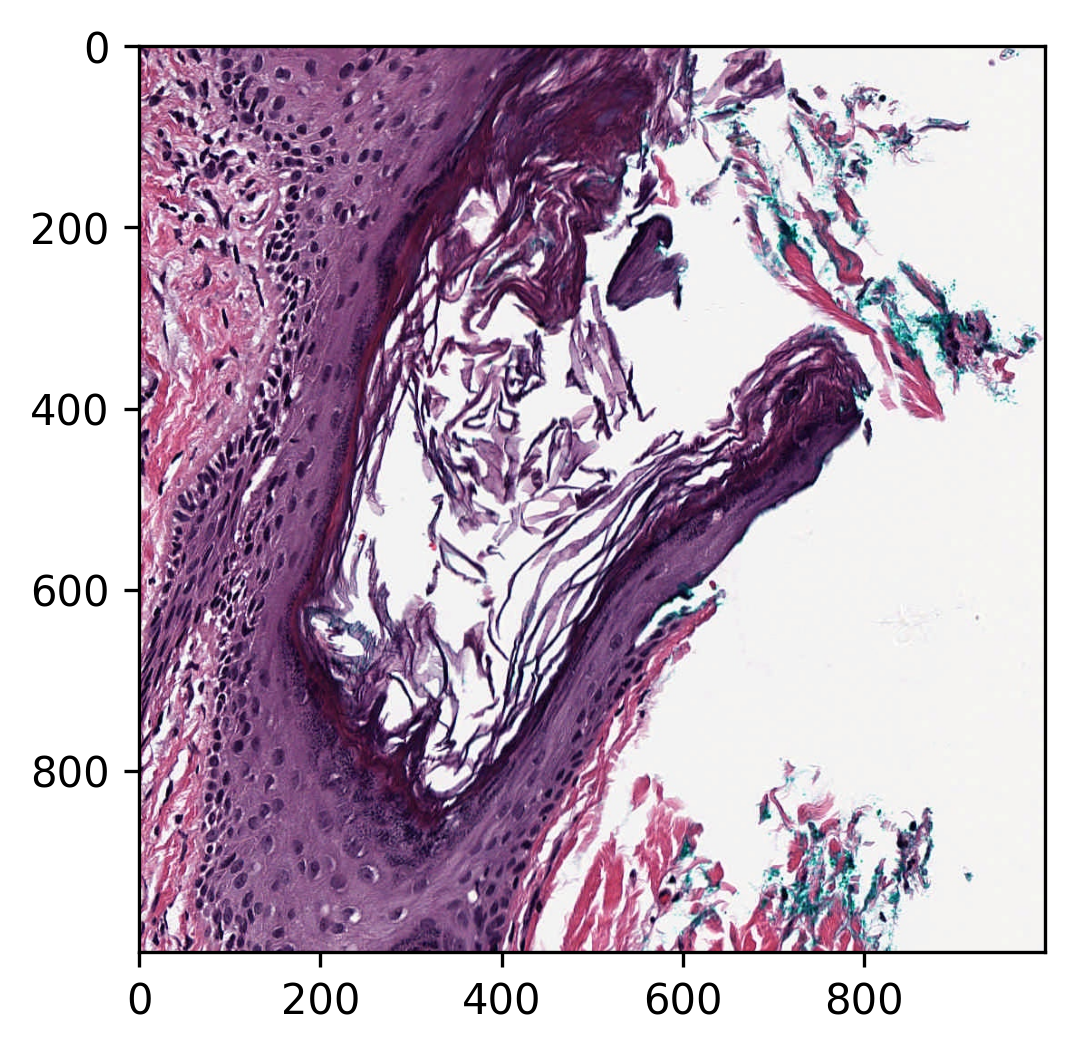

In [16]:
sample_tile = cv2.imread('%s/tmp/%s/%s' % (run_dir, sample_file_name, tile_summary.iloc[4]['Tile_Name']))
sample_tile = cv2.cvtColor(sample_tile, cv2.COLOR_BGR2RGB)

plt.imshow(sample_tile)